In [1]:
from os import getcwd, listdir
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
DATASET = getcwd() + "/dataset/custom/"
CLASSES = 3
IMG_WIDTH = 300
IMG_HEIGHT = 200
BATCH_SIZE = 2
NB_TRAIN_SAMPLES = 24
NB_VALIDATION_SAMPLES = 6
EPOCHS = 50

In [3]:
DATASET

'/home/amogh/Documents/Study/PiRockPaperScissors/notebooks/dataset/custom/'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    DATASET,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
)

validation_generator = test_datagen.flow_from_directory(
    DATASET,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 24 images belonging to 3 classes.
Found 6 images belonging to 3 classes.


In [5]:
model = models.Sequential()
model.add(
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(CLASSES, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 99, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 97, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 46, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 209024)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

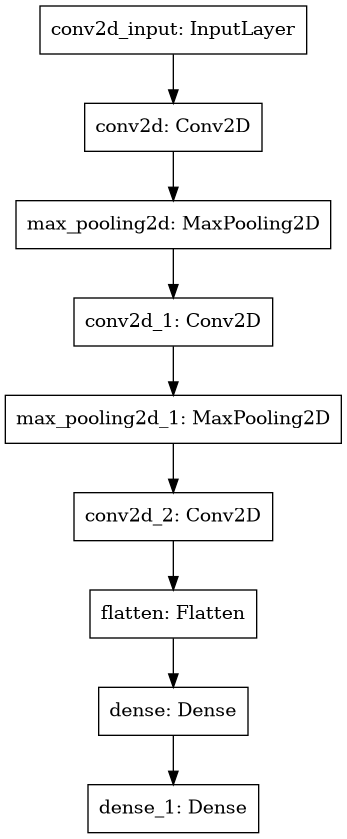

In [6]:
plot_model(model)

In [7]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=5, verbose=1, restore_best_weights=True
)

callbacks = [earlystop]

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = model.fit(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE,
)

Epoch 1/50
12/12 [==============================] - 1s 52ms/step - loss: 1.7885 - accuracy: 0.2083 - val_loss: 1.1435 - val_accuracy: 0.3333
Epoch 2/50
12/12 [==============================] - 0s 33ms/step - loss: 1.1420 - accuracy: 0.2917 - val_loss: 1.0980 - val_accuracy: 0.3333
Epoch 3/50
12/12 [==============================] - 0s 33ms/step - loss: 1.1837 - accuracy: 0.3750 - val_loss: 1.0962 - val_accuracy: 0.3333
Epoch 4/50
12/12 [==============================] - 0s 33ms/step - loss: 1.1080 - accuracy: 0.5000 - val_loss: 1.0924 - val_accuracy: 0.3333
Epoch 5/50
12/12 [==============================] - 0s 30ms/step - loss: 1.1226 - accuracy: 0.4167 - val_loss: 1.0944 - val_accuracy: 0.3333
Epoch 6/50
12/12 [==============================] - 0s 34ms/step - loss: 1.1140 - accuracy: 0.3333 - val_loss: 1.0677 - val_accuracy: 0.3333
Epoch 7/50
12/12 [==============================] - 0s 33ms/step - loss: 1.0198 - accuracy: 0.4583 - val_loss: 0.8010 - val_accuracy: 0.6667
Epoch 8/50
12

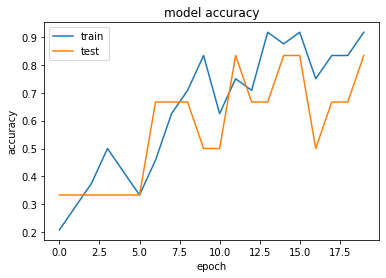

In [8]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

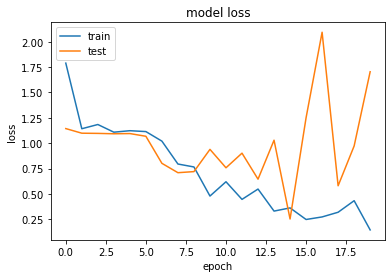

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [10]:
model.save("rps-cnn.h5")

In [11]:
model.save_weights("rps-cnn-weights.h5")

In [12]:
loaded_model = load_model(getcwd() + "/rps-cnn.h5")

In [13]:
Y_pred = loaded_model.predict_generator(
    validation_generator, NB_VALIDATION_SAMPLES // BATCH_SIZE + 1
)
y_pred = np.argmax(Y_pred, axis=1)

class_labels = {v: k for k, v in validation_generator.class_indices.items()}

print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred))

print("Classification Report")
target_names = list(class_labels.values())
print(
    classification_report(
        validation_generator.classes, y_pred, target_names=target_names
    )
)

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[1 1 0]
 [0 2 0]
 [0 0 2]]
Classification Report
              precision    recall  f1-score   support

       paper       1.00      0.50      0.67         2
        rock       0.67      1.00      0.80         2
     scissor       1.00      1.00      1.00         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6



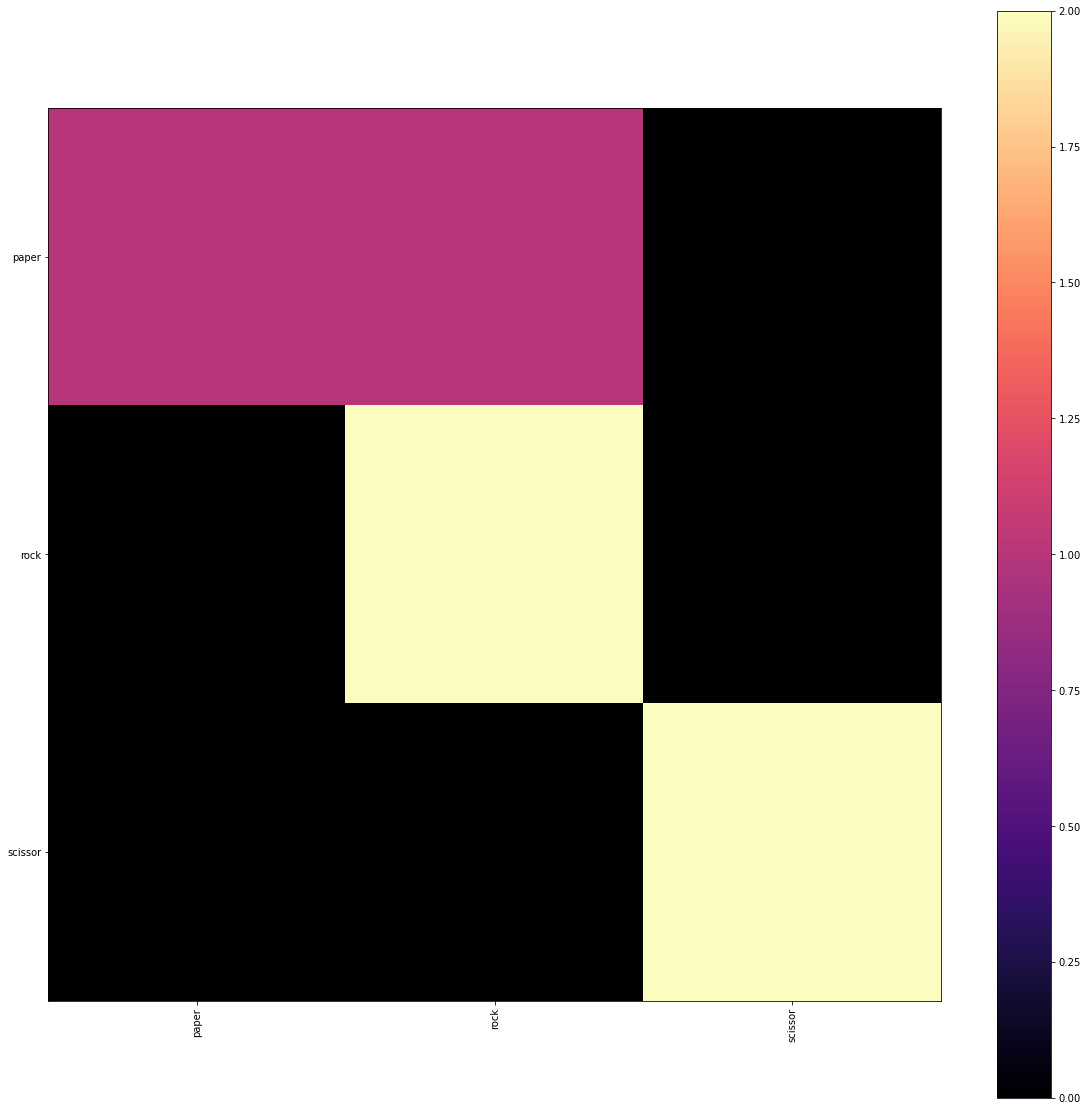

In [14]:
plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)
plt.imshow(cnf_matrix, interpolation='nearest', cmap = "magma")
plt.colorbar()

classes = list(class_labels.values())

tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


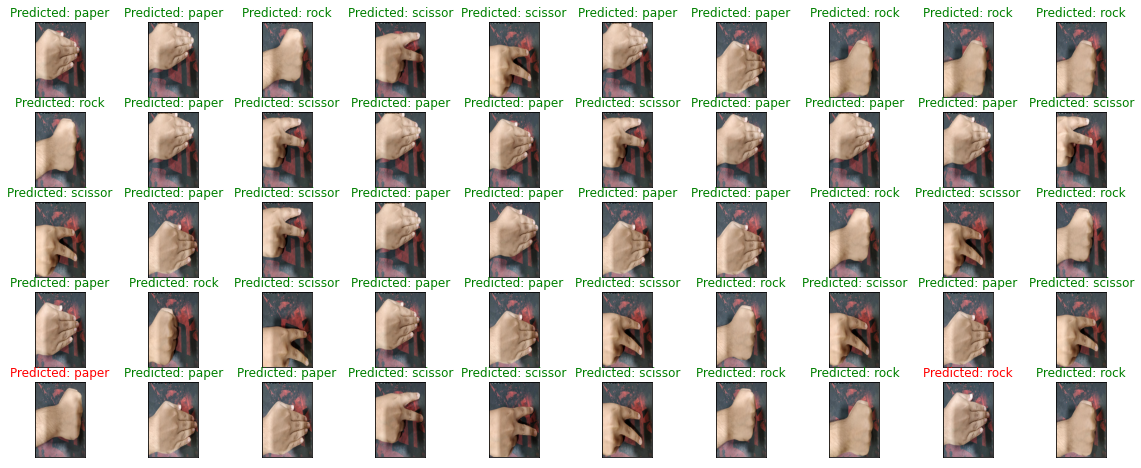

In [15]:
path = DATASET

fig = plt.figure(figsize=(20, 8))


def predictedLabelColor(original, predicted):
    if original == predicted:
        return "green"
    else:
        return "red"


for i in range(50):
    rps_names = listdir(path)
    rps_names_folders = listdir(path)
    random_rps_index = np.random.randint(0, len(rps_names))
    rps_name = rps_names_folders[random_rps_index]

    rps_images_path = path + "/" + rps_name
    rps_images = listdir(rps_images_path)
    random_rps_image_index = np.random.randint(0, len(rps_images))
    rps_image = rps_images[random_rps_image_index]
    rps_image_path = rps_images_path + "/" + rps_image

    result_image_array = image.img_to_array(
        image.load_img(rps_image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    )
    normalized_result = result_image_array * 1.0 / 255
    expanded_result = np.expand_dims(normalized_result, axis=0)
    classes = loaded_model.predict_classes(expanded_result, batch_size=10)
    predicted_label = class_labels[classes[0]]

    ax = fig.add_subplot(5, 10, 1 + i, xticks=[], yticks=[])
    ax.set_title(
        "Predicted: {}".format(predicted_label),
        color=predictedLabelColor(rps_name, predicted_label),
    )
    plt.imshow(normalized_result)

plt.show()